In [31]:
# Import our dependencies
from sqlalchemy import create_engine
from config import user
from config import password2
from urllib import parse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint

### Connect to the database and extract data into a dataframe

In [32]:
# Creating a connection string for the Glassdoor database
protocol="postgresql"
username=user
password=parse.quote(password2)
host="localhost"
port=5432
database_name="Glassdoor_Reviews"

Con_Str=f"{protocol}://{username}:{password}@{host}:{port}/{database_name}"
        
# Create an engine instance
Con = create_engine(Con_Str)

# Connect to PostgreSQL server
dbConnection = Con.connect();

# Read data from PostgreSQL database table and load into a DataFrame instance
df = pd.read_sql("select * from glassdoor", dbConnection);

# Close the database connection
dbConnection.close();

In [33]:
# Display the dataframe
df.head(5)

,firm,date_review,job_title,current,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons
0,AFH-Wealth-Management,2020-10-01,Office Administrator,"Former Employee, more than 3 years","Bromsgrove, England, England",2,1.0,3.0,1.0,1.0,2.0,2.0,x,o,x,The people both make and destroy this place,"Great people in some places, excellent Christm...","Poor pay, huge gap for pay between senior mana..."
1,AFH-Wealth-Management,2021-02-05,Quality Control,Former Employee,"Birmingham, England, England",1,3.0,1.0,2.0,1.0,1.0,1.0,x,o,o,Very low salaries,"Majority of the people there are lovely, and t...",Salaries are much lower than market competitor...
2,AFH-Wealth-Management,2021-02-07,IFA Administrator,"Former Employee, less than 1 year","Bromsgrove, England, England",4,3.0,3.0,4.0,4.0,4.0,2.0,v,o,v,Good,"Nice environment, love people, not too stressful",Management can be clicky at times
3,AFH-Wealth-Management,2021-02-07,Investment Operations,"Former Employee, more than 1 year","Birmingham, England, England",3,5.0,5.0,4.0,3.0,1.0,2.0,x,o,v,AFH Review,-Great People\n-Heading in a good direction ge...,-Low Salary\n-Middle Management likes to micro...
4,AFH-Wealth-Management,2021-05-12,Client Engagement Executive,"Former Employee, less than 1 year","Birmingham, England, England",1,1.0,2.0,1.0,1.0,1.0,1.0,x,x,x,Terrible- avoid like the plague,"None, they lie about working hours, bonuses, p...",-Unachievable bonus unfairly set by manager\n-...


### Determine the correlation between attributes of the dataset using Seaborn

In [34]:
# compute the correlation matrix
corr = df.corr()
corr

,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt
overall_rating,1.000000,0.576271,0.757659,0.623362,0.686137,0.622077,0.738551
work_life_balance,0.576271,1.000000,0.576312,0.494338,0.399630,0.462999,0.555938
culture_values,0.757659,0.576312,1.000000,0.715903,0.634250,0.577421,0.743550
diversity_inclusion,0.623362,0.494338,0.715903,1.000000,0.544574,0.473536,0.640179
career_opp,0.686137,0.399630,0.634250,0.544574,1.000000,0.577133,0.659614
comp_benefits,0.622077,0.462999,0.577421,0.473536,0.577133,1.000000,0.569976
senior_mgmt,0.738551,0.555938,0.743550,0.640179,0.659614,0.569976,1.000000


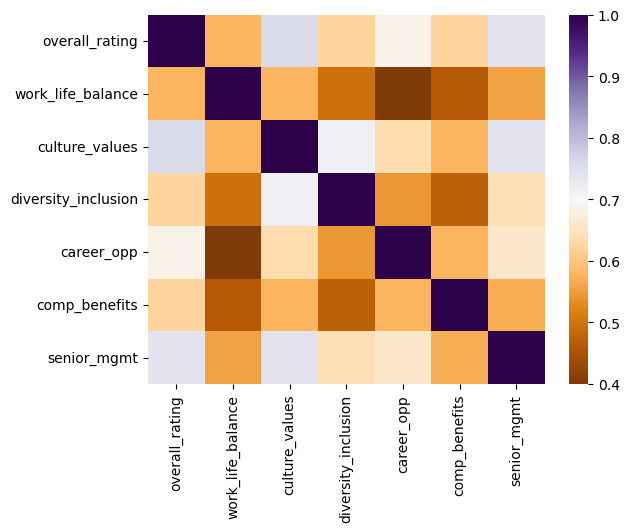

In [35]:
# create a heatmap using Seaborn
sns.heatmap(corr, cmap="PuOr")

# show the plot
plt.show()

### Preprocess the data before creating a model

In [36]:
# List all the attributes of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104510 entries, 0 to 104509
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   firm                 104510 non-null  object 
 1   date_review          104510 non-null  object 
 2   job_title            104510 non-null  object 
 3   current              104510 non-null  object 
 4   location             104510 non-null  object 
 5   overall_rating       104510 non-null  int64  
 6   work_life_balance    104510 non-null  float64
 7   culture_values       104510 non-null  float64
 8   diversity_inclusion  104510 non-null  float64
 9   career_opp           104510 non-null  float64
 10  comp_benefits        104510 non-null  float64
 11  senior_mgmt          104510 non-null  float64
 12  recommend            104510 non-null  object 
 13  ceo_approv           104510 non-null  object 
 14  outlook              104510 non-null  object 
 15  headline         

In [37]:
# Drop the non-beneficial columns.
df_clean = df.drop(["firm", "date_review", "current", "headline", "pros", "cons"], axis=1)
df_clean.head(5)

,job_title,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook
0,Office Administrator,"Bromsgrove, England, England",2,1.0,3.0,1.0,1.0,2.0,2.0,x,o,x
1,Quality Control,"Birmingham, England, England",1,3.0,1.0,2.0,1.0,1.0,1.0,x,o,o
2,IFA Administrator,"Bromsgrove, England, England",4,3.0,3.0,4.0,4.0,4.0,2.0,v,o,v
3,Investment Operations,"Birmingham, England, England",3,5.0,5.0,4.0,3.0,1.0,2.0,x,o,v
4,Client Engagement Executive,"Birmingham, England, England",1,1.0,2.0,1.0,1.0,1.0,1.0,x,x,x


In [38]:
# Drop columns further, considering the seaborn heatmap
df_clean.drop(["work_life_balance", "diversity_inclusion", "comp_benefits"], axis=1, inplace=True)
df_clean.head(5)

,job_title,location,overall_rating,culture_values,career_opp,senior_mgmt,recommend,ceo_approv,outlook
0,Office Administrator,"Bromsgrove, England, England",2,3.0,1.0,2.0,x,o,x
1,Quality Control,"Birmingham, England, England",1,1.0,1.0,1.0,x,o,o
2,IFA Administrator,"Bromsgrove, England, England",4,3.0,4.0,2.0,v,o,v
3,Investment Operations,"Birmingham, England, England",3,5.0,3.0,2.0,x,o,v
4,Client Engagement Executive,"Birmingham, England, England",1,2.0,1.0,1.0,x,x,x


In [39]:
# List all the available attributes of the dataframe
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104510 entries, 0 to 104509
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   job_title       104510 non-null  object 
 1   location        104510 non-null  object 
 2   overall_rating  104510 non-null  int64  
 3   culture_values  104510 non-null  float64
 4   career_opp      104510 non-null  float64
 5   senior_mgmt     104510 non-null  float64
 6   recommend       104510 non-null  object 
 7   ceo_approv      104510 non-null  object 
 8   outlook         104510 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 7.2+ MB


In [40]:
df_clean.nunique()

job_title         18440
location           6229
overall_rating        5
culture_values        5
career_opp            5
senior_mgmt           5
recommend             3
ceo_approv            4
outlook               4
dtype: int64

In [41]:
# Look at location value counts for binning
location_counts = df_clean["location"].value_counts()
location_counts

London, England, England    12675
Bangalore                    5698
New York, NY                 4385
Hyderābād                    2563
Mumbai                       1960
                            ...  
Menifee Lakes, CA               1
Craigburn Farm                  1
Versailles                      1
Watkinsville, GA                1
Wijnegem, Antwerp               1
Name: location, Length: 6229, dtype: int64

In [42]:
# Choose a cutoff value and create a list of location to be replaced

location_to_replace = list(location_counts[location_counts < 500].index)

# Replace in dataframe
for app in location_to_replace:
    df_clean["location"] = df_clean["location"].replace(app,"Other")

# Check to make sure binning was successful
df_clean["location"].value_counts()

Other                                          50472
London, England, England                       12675
Bangalore                                       5698
New York, NY                                    4385
Hyderābād                                       2563
Mumbai                                          1960
Gurgaon, Haryana, Haryana                       1935
Singapore                                       1829
Dublin, Dublin                                  1714
Pune                                            1645
Toronto, ON                                     1408
Manchester, England, England                    1364
Chicago, IL                                     1172
Hong Kong                                       1084
San Francisco, CA                               1032
Sydney                                          1009
Birmingham, England, England                     997
Glasgow, Scotland, Scotland                      971
Leeds, England, England                       

In [43]:
# Look at job_title value counts for binning
job_title_counts = df_clean["job_title"].value_counts()
job_title_counts

 Manager                         2582
 Anonymous Employee              2523
 Consultant                      2247
 Software Engineer               1945
 Associate                       1925
                                 ... 
 Financial Operations Manager       1
 Digital Advertising Analyst        1
 Informantion Systems               1
 Quality Assurance/Compliance       1
 Senior Experience Designer         1
Name: job_title, Length: 18440, dtype: int64

In [44]:
# Choose a cutoff value and create a list of job_title to be replaced

job_title_to_replace = list(job_title_counts[job_title_counts < 500].index)

# Replace in dataframe
for app in job_title_to_replace:
    df_clean["job_title"] = df_clean["job_title"].replace(app,"Other")

# Check to make sure binning was successful
df_clean["job_title"].value_counts()

Other                               74710
 Manager                             2582
 Anonymous Employee                  2523
 Consultant                          2247
 Software Engineer                   1945
 Associate                           1925
 Senior Consultant                   1836
 Analyst                             1717
 Senior Associate                    1316
 Crew Member                         1177
 Assistant Manager                   1110
 Customer Assistant                   967
 Director                             886
 Sales Assistant                      880
 Cashier                              846
 Project Manager                      843
 Senior Manager                       830
 Vice President                       825
 Business Analyst                     799
 Senior Software Engineer             789
 Customer Service Representative      748
 Sales Associate                      688
 Mcdonalds Crew Member                629
 Audit Associate                  

In [45]:
# Convert categorical data to numeric with `pd.get_dummies`
df_numeric = pd.get_dummies(df_clean)
df_numeric.head()

,overall_rating,culture_values,career_opp,senior_mgmt,job_title_ Analyst,job_title_ Anonymous Employee,job_title_ Assistant Manager,job_title_ Associate,job_title_ Audit Associate,job_title_ Business Analyst,...,recommend_v,recommend_x,ceo_approv_o,ceo_approv_r,ceo_approv_v,ceo_approv_x,outlook_o,outlook_r,outlook_v,outlook_x
0,2,3.0,1.0,2.0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
1,1,1.0,1.0,1.0,0,0,0,0,0,0,...,0,1,1,0,0,0,1,0,0,0
2,4,3.0,4.0,2.0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
3,3,5.0,3.0,2.0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,1,0
4,1,2.0,1.0,1.0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1


In [46]:
# compute the correlation matrix
corr_numeric = df_numeric.corr()
corr_numeric

,overall_rating,culture_values,career_opp,senior_mgmt,job_title_ Analyst,job_title_ Anonymous Employee,job_title_ Assistant Manager,job_title_ Associate,job_title_ Audit Associate,job_title_ Business Analyst,...,recommend_v,recommend_x,ceo_approv_o,ceo_approv_r,ceo_approv_v,ceo_approv_x,outlook_o,outlook_r,outlook_v,outlook_x
overall_rating,1.000000,0.757659,0.686137,0.738551,-0.000585,-0.017099,-0.000986,0.001996,-0.015475,0.009066,...,0.570500,-0.638333,-0.025930,-0.223492,0.396253,-0.364752,-0.030841,-0.201697,0.459624,-0.453700
culture_values,0.757659,1.000000,0.634250,0.743550,0.007806,-0.014953,-0.002595,0.006388,-0.007749,0.014597,...,0.525544,-0.590799,-0.026400,-0.230783,0.392626,-0.343796,-0.022538,-0.201935,0.429931,-0.413973
career_opp,0.686137,0.634250,1.000000,0.659614,0.015264,-0.014339,0.011482,0.032758,0.025307,0.015250,...,0.452110,-0.511108,-0.013559,-0.206512,0.341869,-0.306096,-0.021967,-0.201568,0.415752,-0.391382
senior_mgmt,0.738551,0.743550,0.659614,1.000000,0.009226,-0.011855,-0.003320,0.008956,-0.001057,0.010869,...,0.501938,-0.564422,-0.024065,-0.244181,0.401224,-0.341788,-0.024869,-0.220646,0.443252,-0.407481
job_title_ Analyst,-0.000585,0.007806,0.015264,0.009226,1.000000,-0.020328,-0.013391,-0.017704,-0.009763,-0.011344,...,-0.009840,-0.005342,0.013896,-0.014900,0.003714,-0.005708,0.014620,-0.010894,0.003946,-0.009997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ceo_approv_x,-0.364752,-0.343796,-0.306096,-0.341788,-0.005708,0.014844,-0.005897,-0.012179,-0.011521,-0.010952,...,-0.254612,0.375534,-0.149249,-0.149856,-0.235088,1.000000,-0.099084,-0.010716,-0.194621,0.466917
outlook_o,-0.030841,-0.022538,-0.021967,-0.024869,0.014620,0.003632,0.003531,0.027956,0.018019,0.007633,...,-0.449566,-0.158924,0.638599,-0.218363,-0.314034,-0.099084,1.000000,-0.238347,-0.466241,-0.149338
outlook_r,-0.201697,-0.201935,-0.201568,-0.220646,-0.010894,-0.004929,-0.009944,-0.021717,0.000400,-0.005707,...,-0.071904,0.237526,-0.157722,0.417345,-0.219945,-0.010716,-0.238347,1.000000,-0.542256,-0.173686
outlook_v,0.459624,0.429931,0.415752,0.443252,0.003946,-0.008442,0.008151,0.006854,-0.007962,0.005215,...,0.596740,-0.367910,-0.293562,-0.208520,0.530656,-0.194621,-0.466241,-0.542256,1.000000,-0.339755


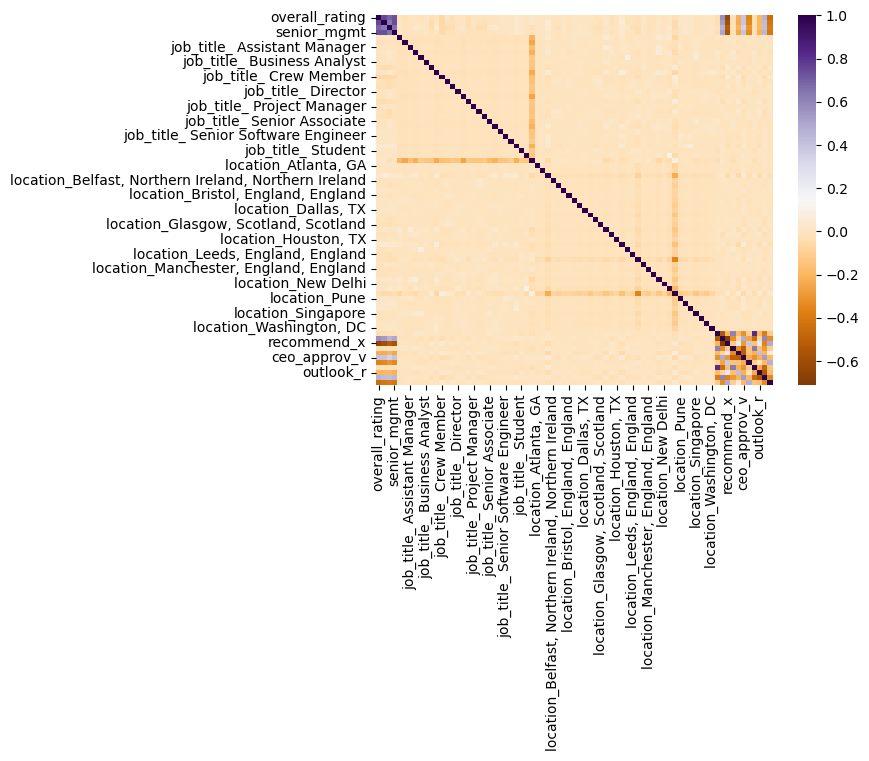

In [47]:
# create a heatmap using Seaborn
sns.heatmap(corr_numeric, cmap="PuOr")

# show the plot
plt.show()

In [48]:
# Drop the non-beneficial columns.
df_clean1 = df.drop(["firm", "date_review", "current", "headline", "pros", "cons"], axis=1)
df_clean1.head(5)

,job_title,location,overall_rating,work_life_balance,culture_values,diversity_inclusion,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook
0,Office Administrator,"Bromsgrove, England, England",2,1.0,3.0,1.0,1.0,2.0,2.0,x,o,x
1,Quality Control,"Birmingham, England, England",1,3.0,1.0,2.0,1.0,1.0,1.0,x,o,o
2,IFA Administrator,"Bromsgrove, England, England",4,3.0,3.0,4.0,4.0,4.0,2.0,v,o,v
3,Investment Operations,"Birmingham, England, England",3,5.0,5.0,4.0,3.0,1.0,2.0,x,o,v
4,Client Engagement Executive,"Birmingham, England, England",1,1.0,2.0,1.0,1.0,1.0,1.0,x,x,x


In [49]:
# Drop columns further, considering the seaborn heatmap
df_clean1.drop(["work_life_balance", "diversity_inclusion", "comp_benefits", "job_title", "location"], axis=1, inplace=True)
df_clean1.head(5)

,overall_rating,culture_values,career_opp,senior_mgmt,recommend,ceo_approv,outlook
0,2,3.0,1.0,2.0,x,o,x
1,1,1.0,1.0,1.0,x,o,o
2,4,3.0,4.0,2.0,v,o,v
3,3,5.0,3.0,2.0,x,o,v
4,1,2.0,1.0,1.0,x,x,x


In [50]:
# Convert categorical data to numeric with `pd.get_dummies`
df_numeric1 = pd.get_dummies(df_clean1)
df_numeric1

,overall_rating,culture_values,career_opp,senior_mgmt,recommend_o,recommend_v,recommend_x,ceo_approv_o,ceo_approv_r,ceo_approv_v,ceo_approv_x,outlook_o,outlook_r,outlook_v,outlook_x
0,2,3.0,1.0,2.0,0,0,1,1,0,0,0,0,0,0,1
1,1,1.0,1.0,1.0,0,0,1,1,0,0,0,1,0,0,0
2,4,3.0,4.0,2.0,0,1,0,1,0,0,0,0,0,1,0
3,3,5.0,3.0,2.0,0,0,1,1,0,0,0,0,0,1,0
4,1,2.0,1.0,1.0,0,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104505,4,4.0,4.0,5.0,0,1,0,0,0,1,0,0,0,1,0
104506,4,4.0,3.0,3.0,0,1,0,0,1,0,0,0,0,1,0
104507,5,5.0,5.0,5.0,0,1,0,0,0,1,0,0,0,1,0
104508,5,5.0,4.0,4.0,0,1,0,0,0,1,0,0,0,1,0


In [51]:
# Split our preprocessed data into our features and target arrays
X = df_numeric1.drop("overall_rating", axis=1)
y = df_numeric1["overall_rating"]

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [52]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Compile, Train and Evaluate the Model

In [53]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.

# Size of data is the number of input features
input_features = X.shape[1]
print("Input Features:",input_features)

# Size of the output layer
output_layer_size = 1
print("Output Layer Size:",output_layer_size)
 
# The number of hidden neurons here is less than twice the size of the input layer    
hidden_nodes_1 = (input_features * 2) - 1
print("Hidden nodes in layer 1:", hidden_nodes_1)

# The number of hidden neurons here is 2/3 the size of the input layer, plus the size of the output layer
nodes2 = input_features * (2/3)
hidden_nodes_2 = round(nodes2,0) + output_layer_size
print("Hidden nodes in layer 2:", int(hidden_nodes_2))

Input Features: 14
Output Layer Size: 1
Hidden nodes in layer 1: 27
Hidden nodes in layer 2: 10


In [54]:
# Create a Keras Sequential model
nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_1, activation="relu", input_dim=input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="softmax"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 27)                405       
                                                                 
 dense_4 (Dense)             (None, 10)                280       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 696
Trainable params: 696
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [56]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=10)

Epoch 1/10
2450/2450 [==============================] - 6s 2ms/step - loss: -36143.7500 - accuracy: 0.0578
Epoch 2/10
2450/2450 [==============================] - 5s 2ms/step - loss: -405602.9062 - accuracy: 0.0578
Epoch 3/10
2450/2450 [==============================] - 5s 2ms/step - loss: -1385033.2500 - accuracy: 0.0578
Epoch 4/10
2450/2450 [==============================] - 5s 2ms/step - loss: -3138442.2500 - accuracy: 0.0578
Epoch 5/10
2450/2450 [==============================] - 5s 2ms/step - loss: -5830011.5000 - accuracy: 0.0578
Epoch 6/10
2450/2450 [==============================] - 5s 2ms/step - loss: -9639778.0000 - accuracy: 0.0578
Epoch 7/10
2450/2450 [==============================] - 5s 2ms/step - loss: -14722609.0000 - accuracy: 0.0578
Epoch 8/10
2450/2450 [==============================] - 5s 2ms/step - loss: -21255494.0000 - accuracy: 0.0578
Epoch 9/10
2450/2450 [==============================] - 5s 2ms/step - loss: -29377412.0000 - accuracy: 0.0578
Epoch 10/10
2450/24

In [57]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

817/817 - 1s - loss: -4.5225e+07 - accuracy: 0.0576 - 1s/epoch - 2ms/step
Loss: -45224504.0, Accuracy: 0.05756276845932007
